In [ ]:
# Block 1: Imports and Setup
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Set random seed for reproducibility
torch.manual_seed(44)
np.random.seed(44)

Using device: cpu


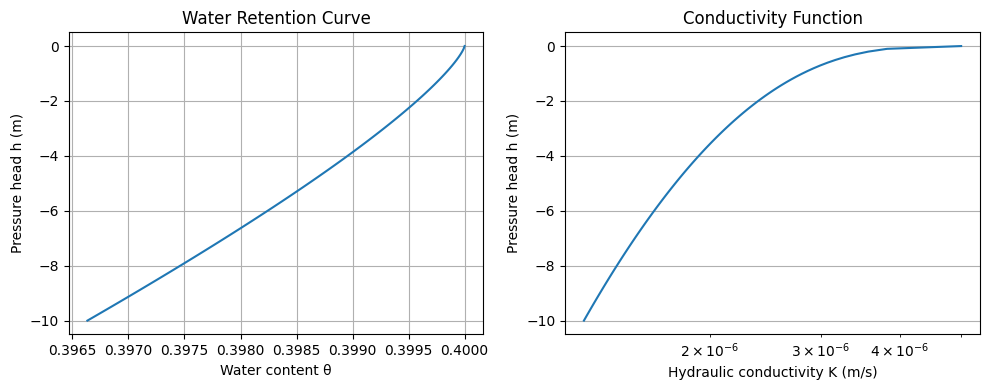

In [165]:
# Block 2: Van Genuchten Soil Hydraulic Functions (simple version)
class VanGenuchten:
    def __init__(self, theta_s=0.45, theta_r=0.05, alpha=0.02, n=1.5, Ks=1e-5, l=0.5):
        self.theta_s, self.theta_r = theta_s, theta_r
        self.alpha, self.n, self.m = alpha, n, 1.0 - 1.0/n
        self.Ks, self.l = Ks, l
        self._tiny = 1e-12  # minimal guard

    def theta(self, h):
        abs_h = torch.abs(h)
        denom = (1.0 + (self.alpha * abs_h).pow(self.n)).pow(self.m)
        denom = denom + self._tiny                      # avoid 0
        theta_unsat = self.theta_r + (self.theta_s - self.theta_r) / denom
        return torch.where(h >= 0.0,
                           torch.as_tensor(self.theta_s, device=h.device, dtype=h.dtype),
                           theta_unsat)

    def Se(self, h):
        th = self.theta(h)
        Se = (th - self.theta_r) / (self.theta_s - self.theta_r + self._tiny)
        # keep in (0,1) to avoid fractional-power NaNs
        return torch.clamp(Se, 1e-6, 1.0 - 1e-6)

    def K(self, h):
        Se = self.Se(h)
        Se_1m = Se.pow(1.0 / self.m)
        K_unsat = self.Ks * (Se.pow(self.l)) * (1.0 - (1.0 - Se_1m).pow(self.m)).pow(2)
        return torch.where(h >= 0.0,
                           torch.as_tensor(self.Ks, device=h.device, dtype=h.dtype),
                           torch.clamp(K_unsat, 0.0, self.Ks))  # keep nonnegative & ≤ Ks

# Test the Van Genuchten functions
if __name__ == "__main__":
    # Test with sample pressure heads
    soil = VanGenuchten(theta_s=0.4, theta_r=0.1, alpha=0.01, n=1.3, Ks=5e-6)
    h_test = torch.linspace(-10, 0, 100).unsqueeze(1)

    theta_test = soil.theta(h_test)
    K_test = soil.K(h_test)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(theta_test.detach().numpy(), h_test.numpy())
    ax1.set_xlabel('Water content θ')
    ax1.set_ylabel('Pressure head h (m)')
    ax1.set_title('Water Retention Curve')
    ax1.grid(True)

    ax2.semilogx(K_test.detach().numpy(), h_test.numpy())
    ax2.set_xlabel('Hydraulic conductivity K (m/s)')
    ax2.set_ylabel('Pressure head h (m)')
    ax2.set_title('Conductivity Function')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()




In [166]:
# Block 3: Neural Network Architectures (no custom init)
class PressureHeadNet(nn.Module):
    """Neural network for pressure head h(z,t)"""
    def __init__(self, hidden_dim=50, num_layers=4):
        super().__init__()

        layers = []
        layers.append(nn.Linear(2, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, z, t):
        inputs = torch.cat([z, t], dim=1)
        h = self.net(inputs)
        # Constrain pressure head to reasonable range
        return torch.clamp(h, -50.0, 5.0)

class WaterTableNet(nn.Module):
    """Neural network for water table depth z_b(t) with constraints"""
    def __init__(self, hidden_dim=20, num_layers=2):
        super().__init__()

        layers = []
        layers.append(nn.Linear(1, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, t):
        zb = self.net(t)
        # Ensure water table depth is positive and within reasonable bounds
        return torch.clamp(torch.abs(zb) + 0.5, 0.5, 5.0)

# Test the neural networks
if __name__ == "__main__":
    # Test pressure head network
    h_net = PressureHeadNet().to(device)

    # Create test inputs
    z_test = torch.linspace(-2, 0, 10).unsqueeze(1).to(device)
    t_test = torch.ones_like(z_test).to(device)

    h_output = h_net(z_test, t_test)
    print(f"Pressure head network output shape: {h_output.shape}")
    print(f"Sample pressure heads: {h_output[:5].flatten()}")

    # Test water table network
    zb_net = WaterTableNet().to(device)

    t_test = torch.linspace(0, 10, 10).unsqueeze(1).to(device)
    zb_output = zb_net(t_test)
    print(f"Water table network output shape: {zb_output.shape}")
    print(f"Sample water table depths: {zb_output[:5].flatten()}")

    print("Neural networks working correctly!")


Pressure head network output shape: torch.Size([10, 1])
Sample pressure heads: tensor([0.0953, 0.0959, 0.0959, 0.0949, 0.0925], grad_fn=<ViewBackward0>)
Water table network output shape: torch.Size([10, 1])
Sample water table depths: tensor([0.6817, 0.6029, 0.6214, 0.6586, 0.6847], grad_fn=<ViewBackward0>)
Neural networks working correctly!


In [167]:
# Block 4: Main PINN Model Class (minimal, no extra "stability" tweaks)
class RichardsPINN(nn.Module):
    """PINN for Richards equation with moving boundary"""
    def __init__(self, soil_params, q0_data, Sy=0.15):
        super().__init__()
        self.h_net = PressureHeadNet()
        self.zb_net = WaterTableNet()
        self.soil = VanGenuchten(**soil_params)
        self.Sy = torch.tensor(Sy, device=device)  # constant storage coefficient
        self.zr = 0.5  # rooting depth (kept simple)
        
        # Store surface flux data (time, flux) pairs - now required
        if q0_data is None:
            raise ValueError("q0_data is required! Provide (times, fluxes) tuple.")
        
        self.q0_times = torch.tensor(q0_data[0], dtype=torch.float32, device=device)
        self.q0_values = torch.tensor(q0_data[1], dtype=torch.float32, device=device)

    def forward(self, z, t):
        """Return h(z,t) and z_b(t)"""
        h = self.h_net(z, t)
        zb = self.zb_net(t)
        return h, zb

    def surface_flux(self, t):
        """Prescribed surface flux q0(t) - interpolated from input data"""
        # Interpolate from provided data
        # Simple linear interpolation using torch operations
        t_flat = t.flatten()
        q0_interp = torch.zeros_like(t_flat)
        
        for i in range(len(t_flat)):
            t_val = t_flat[i]
            # Find surrounding points for interpolation
            if t_val <= self.q0_times[0]:
                q0_interp[i] = self.q0_values[0]
            elif t_val >= self.q0_times[-1]:
                q0_interp[i] = self.q0_values[-1]
            else:
                # Linear interpolation
                idx = torch.searchsorted(self.q0_times, t_val)
                if idx == 0:
                    q0_interp[i] = self.q0_values[0]
                else:
                    t1, t2 = self.q0_times[idx-1], self.q0_times[idx]
                    q1, q2 = self.q0_values[idx-1], self.q0_values[idx]
                    alpha = (t_val - t1) / (t2 - t1)
                    q0_interp[i] = q1 + alpha * (q2 - q1)
        
        return q0_interp.reshape_as(t)

    def root_uptake(self, z, t):
        """Simple root uptake S(z,t) in the root zone"""
        S_max = 1e-7
        return torch.where(z >= -self.zr,
                           torch.full_like(z, S_max),
                           torch.zeros_like(z))

    def compute_derivatives(self, h, z, t):
        """Raw autograd derivatives (no clipping)"""
        theta_h = self.soil.theta(h)
        dtheta_dt = torch.autograd.grad(theta_h.sum(), t, create_graph=True)[0]
        dh_dz     = torch.autograd.grad(h.sum(),       z, create_graph=True)[0]
        K_h       = self.soil.K(h)
        q         = -K_h * (dh_dz + 1.0)
        dq_dz     = torch.autograd.grad(q.sum(),       z, create_graph=True)[0]
        return dtheta_dt, dq_dz, q, K_h

    def pde_residual(self, z, t):
        """Richards equation: ∂θ/∂t = ∂q/∂z - S"""
        z = z.requires_grad_(True)
        t = t.requires_grad_(True)
        h, _ = self(z, t)
        dtheta_dt, dq_dz, _, _ = self.compute_derivatives(h, z, t)
        S = self.root_uptake(z, t)
        return dtheta_dt - dq_dz + S

    def surface_bc_residual(self, t):
        """Flux BC at z=0: q(0,t) = q0(t)"""
        t = t.requires_grad_(True)
        z0 = torch.zeros_like(t, requires_grad=True, device=t.device)
        h0, _ = self(z0, t)
        K0 = self.soil.K(h0)
        dh_dz_0 = torch.autograd.grad(h0.sum(), z0, create_graph=True)[0]
        q_surf = -K0 * (dh_dz_0 + 1.0)
        q0 = self.surface_flux(t)
        return q_surf - q0

    def water_table_head_residual(self, t):
        """Head BC at WT: h(-z_b(t), t) = 0"""
        z_dummy = torch.zeros_like(t)
        _, zb = self(z_dummy, t)
        h_wt, _ = self(-zb, t)
        return h_wt

    def water_table_kinematic_residual(self, t):
        """WT kinematic: dz_b/dt = -q(-z_b,t)/S_y"""
        t = t.requires_grad_(True)
        _, zb = self(torch.zeros_like(t), t)
        dzb_dt = torch.autograd.grad(zb.sum(), t, create_graph=True)[0]
        z_wt = (-zb).requires_grad_(True)
        h_wt, _ = self(z_wt, t)
        K_wt = self.soil.K(h_wt)
        dh_dz_wt = torch.autograd.grad(h_wt.sum(), z_wt, create_graph=True)[0]
        q_wt = -K_wt * (dh_dz_wt + 1.0)
        return dzb_dt + q_wt / self.Sy

    def initial_conditions_residual(self, z, t0):
        """IC: hydrostatic guess h(z,t0)=z+z_b(t0), and z_b(t0)=1.5"""
        h, zb = self(z, t0)
        h_ic = z + zb
        zb_ic = torch.tensor(1.5, device=z.device).expand_as(zb)
        return h - h_ic, zb - zb_ic


# --- Minimal smoke test ---
if __name__ == "__main__":
    soil_params = {
        'theta_s': 0.4,
        'theta_r': 0.1,
        'alpha': 0.01,
        'n': 1.3,
        'Ks': 5e-6,
        'l': 0.5,
    }
    
    # Create simple test q0_data
    test_q0_data = ([0.0, 5.0, 10.0], [-5e-7, -5e-7, -5e-7])  # constant for testing

    model = RichardsPINN(soil_params, test_q0_data, Sy=0.15).to(device)
    print("Model created successfully!")
    print(f"# trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    z_test = torch.randn(5, 1, device=device)
    t_test = torch.randn(5, 1, device=device)

    with torch.no_grad():
        h_out, zb_out = model(z_test, t_test)
        print(f"Forward OK: h {h_out.shape}, zb {zb_out.shape}")


Model created successfully!
# trainable params: 8332
Forward OK: h torch.Size([5, 1]), zb torch.Size([5, 1])


In [168]:
# Block 5: Visualization of Results
def plot_results(model, t_max=10.0, z_min=-3.0, z_max=0.0):
    """Plot q0(t), h(z,t), and zb(t) after training"""
    
    model.eval()
    
    # Create time and depth grids
    t_plot = torch.linspace(0, t_max, 100, dtype=torch.float32).unsqueeze(1).to(device)
    z_plot = torch.linspace(z_min, z_max, 50, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Create meshgrid for h(z,t) surface plot
    T, Z = torch.meshgrid(t_plot.squeeze(), z_plot.squeeze(), indexing='ij')
    T_flat = T.flatten().unsqueeze(1)
    Z_flat = Z.flatten().unsqueeze(1)
    
    with torch.no_grad():
        # Surface flux q0(t)
        q0_vals = model.surface_flux(t_plot)
        
        # Water table depth zb(t)
        _, zb_vals = model(torch.zeros_like(t_plot), t_plot)
        
        # Pressure head h(z,t) on the grid
        h_vals, _ = model(Z_flat, T_flat)
        H = h_vals.reshape(T.shape)
    
    # Convert to numpy for plotting
    t_np = t_plot.cpu().numpy().squeeze()
    z_np = z_plot.cpu().numpy().squeeze()
    q0_np = q0_vals.cpu().numpy().squeeze()
    zb_np = zb_vals.cpu().numpy().squeeze()
    T_np = T.cpu().numpy()
    Z_np = Z.cpu().numpy()
    H_np = H.cpu().numpy()
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Surface flux q0(t)
    ax1.plot(t_np, q0_np * 1e6, 'b-', linewidth=2, label='Model q₀(t)')
    
    # Always plot the original data points (since q0_data is now required)
    data_times = model.q0_times.cpu().numpy()
    data_fluxes = model.q0_values.cpu().numpy()
    ax1.scatter(data_times, data_fluxes * 1e6, color='red', s=50, 
               label='Data points', zorder=5)
    ax1.legend()
    
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Surface flux q₀ (μm/s)')
    ax1.set_title('Surface Flux q₀(t)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Water table depth zb(t)
    ax2.plot(t_np, -zb_np, 'r-', linewidth=2)
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Water table depth -zb (m)')
    ax2.set_title('Water Table Depth zb(t)')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Pressure head h(z,t) as contour plot
    contour = ax3.contourf(T_np, Z_np, H_np, levels=20, cmap='viridis')
    ax3.set_xlabel('Time (days)')
    ax3.set_ylabel('Depth z (m)')
    ax3.set_title('Pressure Head h(z,t)')
    plt.colorbar(contour, ax=ax3, label='Pressure head h (m)')
    
    # Plot 4: Pressure head profiles at different times
    times_to_plot = [0, 2.5, 5.0, 7.5, 10.0]
    colors = ['blue', 'green', 'orange', 'red', 'purple']
    
    for i, t_val in enumerate(times_to_plot):
        t_single = torch.tensor([[t_val]], device=device, dtype=torch.float32)
        with torch.no_grad():
            h_profile, _ = model(z_plot, t_single.expand_as(z_plot))
        ax4.plot(h_profile.cpu().numpy().squeeze(), z_np, 
                color=colors[i], linewidth=2, label=f't = {t_val} days')
    
    ax4.set_xlabel('Pressure head h (m)')
    ax4.set_ylabel('Depth z (m)')
    ax4.set_title('Pressure Head Profiles h(z,t)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nResults Summary:")
    print(f"Final water table depth: {-zb_np[-1]:.3f} m")
    print(f"Surface flux range: [{q0_np.min()*1e6:.2f}, {q0_np.max()*1e6:.2f}] μm/s")
    print(f"Pressure head range: [{H_np.min():.3f}, {H_np.max():.3f}] m")




Training with sinusoidal surface flux...
Training for up to 1000 epochs | collocation=1000 | lr=0.001
Domain: z∈[-3.0,0.0], t∈[0.0,10.0]
Convergence: rel_change<1.0e-05, patience=100, window=50
[   1/1000] total=2.390e+00 | PDE=4.414e-12, Surf=2.028e-11, WT(h)=2.756e-03, WT(kin)=6.673e-04, IC(h)=1.393e+00, IC(zb)=9.930e-01
[ 200/1000] total=3.285e-03 | PDE=1.753e-10, Surf=3.702e-11, WT(h)=9.057e-05, WT(kin)=2.885e-04, IC(h)=2.904e-03, IC(zb)=1.884e-06
[ 400/1000] total=1.543e-03 | PDE=1.672e-10, Surf=4.013e-11, WT(h)=4.197e-05, WT(kin)=3.132e-04, IC(h)=1.187e-03, IC(zb)=2.470e-07
[ 600/1000] total=3.348e-04 | PDE=1.337e-10, Surf=3.926e-11, WT(h)=4.411e-06, WT(kin)=1.128e-04, IC(h)=2.176e-04, IC(zb)=3.458e-08
[ 800/1000] total=1.601e-04 | PDE=1.262e-10, Surf=4.430e-11, WT(h)=5.298e-06, WT(kin)=1.103e-04, IC(h)=4.454e-05, IC(zb)=3.638e-09
[1000/1000] total=6.419e-05 | PDE=1.305e-10, Surf=4.357e-11, WT(h)=2.733e-06, WT(kin)=2.933e-05, IC(h)=3.214e-05, IC(zb)=1.567e-10
Training done.


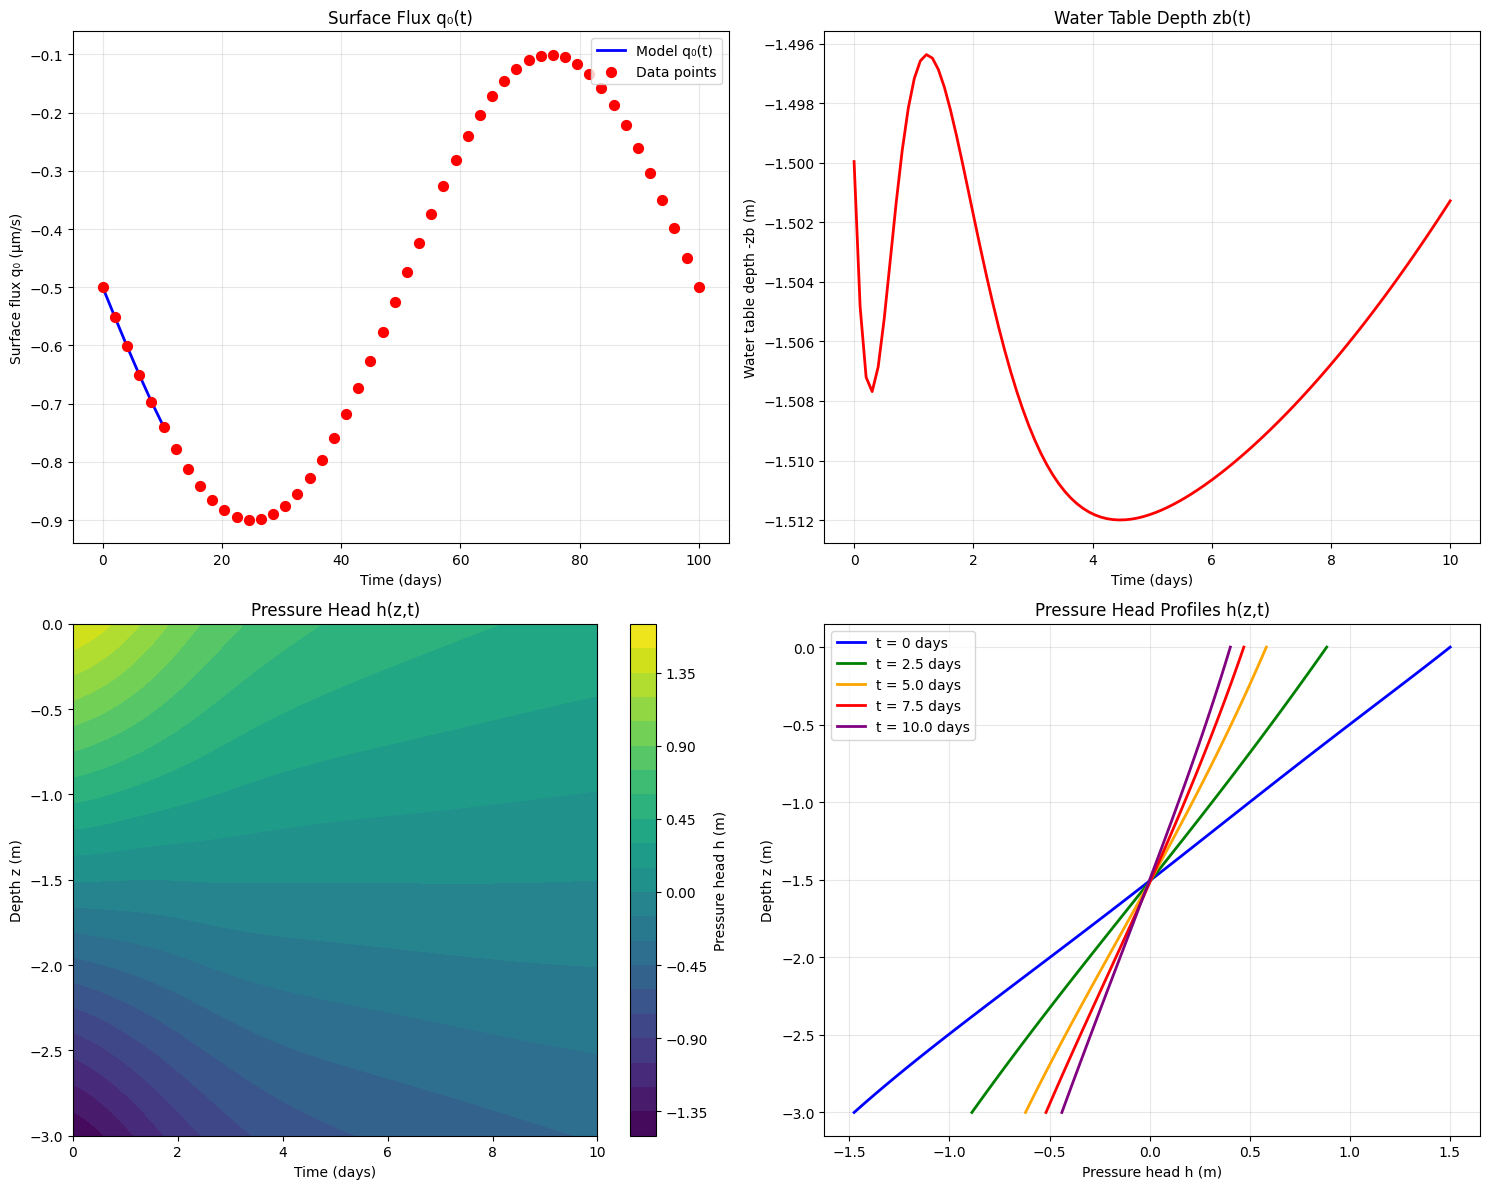


Results Summary:
Final water table depth: -1.501 m
Surface flux range: [-0.73, -0.50] μm/s
Pressure head range: [-1.477, 1.502] m


In [169]:
# Block 6: Example Usage with Custom Surface Flux Data

# Example 1: Sinusoidal surface flux (e.g., seasonal variation)
def create_sinusoidal_q0_data(t_max=100, n_points=50):
    """Create sinusoidal surface flux data"""
    times = np.linspace(0, t_max, n_points)
    # Sinusoidal flux: varies between -1e-6 and -1e-7 m/s
    base_flux = -5e-7
    amplitude = -4e-7
    fluxes = base_flux + amplitude * np.sin(2 * np.pi * times / t_max)
    return times.tolist(), fluxes.tolist()

# Example 2: Step function (e.g., irrigation events)
def create_step_q0_data(t_max=10.0):
    """Create step function surface flux data (irrigation events)"""
    times = [0.0, 2.0, 2.5, 5.0, 5.5, 8.0, 8.5, t_max]
    fluxes = [-1e-7, -1e-7, -2e-6, -2e-6, -1e-7, -1e-7, -3e-6, -3e-6]  # irrigation pulses
    return times, fluxes



# Example usage functions
def train_with_custom_flux(flux_type='sinusoidal', n_epochs=1000):
    """Train PINN with different flux types"""
    
    print(f"Training with {flux_type} surface flux...")
    
    if flux_type == 'sinusoidal':
        q0_data = create_sinusoidal_q0_data()
    elif flux_type == 'step':
        q0_data = create_step_q0_data()
    elif flux_type == 'exponential':
        q0_data = create_exponential_q0_data()
    else:
        raise ValueError(f"Unknown flux type: {flux_type}. Use 'sinusoidal', 'step', or 'exponential'")
    
    # Train the model
    model, losses, comps = train_pinn(
        q0_data,
        n_epochs=n_epochs,
        learning_rate=1e-3,
        n_collocation=1000
    )
    
    # Plot results
    plot_results(model)
    
    return model, losses, comps

# Example: Train with your own data
def train_with_your_data(times, fluxes, n_epochs=2000):
    """
    Train PINN with your custom surface flux data
    
    Args:
        times: list or array of time points (days)
        fluxes: list or array of surface flux values (m/s, negative = downward)
        n_epochs: number of training epochs
    
    Example:
        # Your measurement data
        my_times = [0, 1, 3, 5, 7, 10]  # days
        my_fluxes = [-1e-6, -2e-6, -1e-6, -5e-7, -8e-7, -3e-7]  # m/s
        
        model, losses, comps = train_with_your_data(my_times, my_fluxes, n_epochs=1500)
    """
    q0_data = (times, fluxes)
    
    print(f"Training with custom data: {len(times)} time points")
    print(f"Time range: {min(times):.1f} to {max(times):.1f} days")
    print(f"Flux range: {min(fluxes)*1e6:.1f} to {max(fluxes)*1e6:.1f} μm/s")
    
    model, losses, comps = train_pinn(
        q0_data,
        n_epochs=n_epochs,
        learning_rate=1e-3,
        n_collocation=1000
    )
    
    plot_results(model)
    return model, losses, comps
model_sin, losses_sin, comps_sin = train_with_custom_flux('sinusoidal', n_epochs=1000)



Usage: plot_q0_and_h_surface(model)


Flexible training function ready!
Usage:
model, losses, comps = train_pinn_flexible(q0_data, soil_params, domain_bounds, training_config)


Creating sinusoidal q0_data...
Training with sinusoidal q0_data...
Training for up to 2000 epochs | collocation=1000 | lr=0.001
Domain: z∈[-3.0,0.0], t∈[0.0,10.0]
Convergence: rel_change<1.0e-05, patience=100, window=50
[   1/2000] total=2.463e+00 | PDE=3.031e-15, Surf=2.083e-11, WT(h)=9.112e-03, WT(kin)=3.689e-04, IC(h)=1.634e+00, IC(zb)=8.200e-01
[ 200/2000] total=5.201e-03 | PDE=1.568e-10, Surf=3.760e-11, WT(h)=2.881e-04, WT(kin)=2.117e-03, IC(h)=2.792e-03, IC(zb)=2.990e-06
[ 400/2000] total=9.143e-04 | PDE=1.758e-10, Surf=3.977e-11, WT(h)=8.881e-06, WT(kin)=6.780e-05, IC(h)=8.376e-04, IC(zb)=3.530e-08
[ 600/2000] total=2.067e-04 | PDE=1.593e-10, Surf=4.314e-11, WT(h)=1.541e-05, WT(kin)=6.672e-05, IC(h)=1.245e-04, IC(zb)=1.410e-08
[ 800/2000] total=nan | PDE=nan, Surf=nan, WT(h)=nan, WT(kin)=nan, IC(h)=nan, IC(zb)=nan
[1000/2000] total=nan | PDE=nan, Surf=nan, WT(h)=nan, WT(kin)=nan, IC(h)=nan, IC(zb)=nan
[1200/2000] total=nan | PDE=nan, Surf=nan, WT(h)=nan, WT(kin)=nan, IC(h)=nan, 

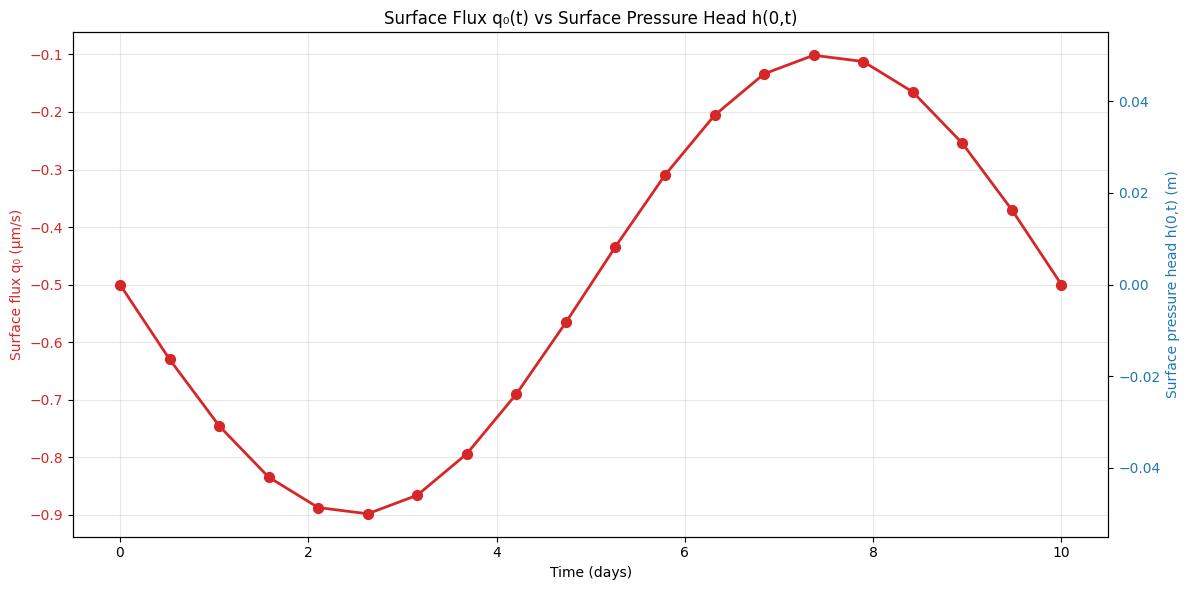

Flexible plotting functions ready!
Usage after training model:
  plot_surface_comparison(model)
  plot_pressure_head_profiles(model, [0, 2.5, 5, 10])
  plot_flux_at_depths(model, [0, -0.5, -1.0, -2.0])
  plot_water_table_evolution(model)
